##### In this notebook is presented a pipeline for the application of the Cayula-Cornillon algorithm to several images, and calculate the respective Frontal Probabilities matrix for the period in question. This pipeline is designed for MUR data, but it will be quite simple to apply this pipeline to other types of data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import xarray as xr
import os
from pathlib import Path
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft2
import cmocean
import cv2
import matplotlib
from matplotlib.colors import ListedColormap
import pickle
plt.rcParams["figure.figsize"] = 14, 12
%matplotlib inline

## Import Data

In [2]:
def get_data(data):
    
    """
    function to get our netCDF file that is stored in the data directory and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #caso se esteja a importar os dados do MUR, renomear as colunas e passar a temperatura para Celsius
    if data.startswith('mur'):
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   
        
    
    return df

In [5]:
df_reanalysis = get_data('IBI2014-2019.nc')   

In [6]:
Aug1_r = df_reanalysis[df_reanalysis['time'] == '2019-08-01 12:00:00']

In [26]:
df_mur_july = get_data('murJuly2019.nc')

In [15]:
df_mur_set = get_data('murSept2019.nc')

In [3]:
df_mur_aug = get_data('murAugust2019.nc')

In [4]:

Aug1_mur = df_mur_aug[df_mur_aug['time'] == '2019-08-01 09:00:00']

In [5]:
Aug15_mur = df_mur_aug[df_mur_aug['time'] == '2019-08-15 09:00:00']

In [5]:
def get_period(df):
    
    """
    Function that receives a dataframe that has SST data for different days 
    and returns a dictionaire of dataframes (one for each different day) (dict_df) and 
    an array with the different dates its possible to find in our dataframe (specificday)
    """
    
    specificday = [pd.Timestamp(dd).strftime("%Y-%m-%d %H:%M:%S") for dd in df['time'].unique()]
    specificday = np.array(specificday, dtype=np.object)
  
    #create a dictionary to store the data frames for each day
    dict_df = {elem : pd.DataFrame for elem in specificday}

    for key in dict_df.keys():
        dict_df[key] = df[:][df['time'] == key]
        
    return dict_df, specificday

#after this function we only have to define the period we want to analyse

In [6]:
dict_df_mur_aug, specificday_mur_aug = get_period(df_mur_aug)


In [27]:
dict_df_mur_july, specificday_mur_july = get_period(df_mur_july)

In [17]:
dict_df_mur_set, specificday_mur_set = get_period(df_mur_set)

In [8]:
dict_df_r, specificday_r = get_period(df_reanalysis)

In [9]:
summer2019_r = specificday_r[(specificday_r >='2019-07-01 12:00:00') & (specificday_r<='2019-09-30 12:00:00')]

## Cayula-Cornillon Algorithm

In [7]:
def getFrontInWindow(w, head, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, 
                     minGlobalPopCohesion, corners):
    
    #empty arrays de xdata, ydata e z
    xdata = np.array([])
    ydata = np.array([])
    z = np.array([])
    exitType=0
    
    #mask is an array with the same shape of w, that is 1 if in that index position w = np.nan and 0 otherwise
    mask = np.isnan(w).astype('int')  
    haveNaNs = np.any(mask[:]).astype('int')  #haveNaNs=1 if mask has 1s (that correspond to NaNs in matrix w)
    n_NaNs=0
    
    
    if haveNaNs:
        n_NaNs = sum(mask.flatten()[:])       # count nr of 1s (NaNs in matrix w) that there are
        if (n_NaNs/len(w.flatten())>0.5):     #window can't have more than 50% of its pixels as NaNs
            exitType=-1
            return None,None,None,exitType  
        
    mi_ma = [np.nanmin(w), np.nanmax(w)]                          #array with minimum and maximum value of w
    n = math.ceil((mi_ma[1]-mi_ma[0])/0.02)                       #number of bins
    bins = np.arange(mi_ma[0], mi_ma[1], 0.02)                    #to define the bins sequence 
    [y, xout] = np.histogram(w[:], bins, mi_ma)                   #y->frequency counts, Xout->bin location
    xout = np.mean(np.vstack([xout[0:-1],xout[1:]]), axis=0)     #xout to be relative to the centers of the bins
    
    
    thresValue = xout[0]        
    totalCount = len(w.flatten()) - n_NaNs    #nr of non NaN pixels 
    threshPopACount = 0
    threshSeparation = -1
    threshPopAMean = 0
    threshPopBMean = 0
    
    w[mask==1] = 0                      #Replace NaNs with 0's (when mask is 1 replace values of array w for 0)
    totalSum = sum(w.flatten())                      #sum of values of matrix w
    totalSumSquares = sum(w.flatten()*w.flatten())   #sum of the squares of the values of w
    
    #In this for loop we are going to discover which line is going to make the best separation between the average
    # of population on the left and on the right (A and B) - and that is going to be the thresValue
    for k in range(1,n-1):     #ignore the first and last candidates (senão seria de 0 a n)
        popASum = sum(y[0:k+1] * xout[0:k+1])    
        popBSum = sum(y[k+1:] * xout[k+1:])  
        popACount = sum(y[0:k+1])     #sum of frequencies (y) from populationA
        popBCount = sum(y[k+1:])      #sum of frequencies (y) from populationB
    
        popAMean = popASum/popACount
        try:                                  #try to avoid the zerodivisionerror that was poping up 
            popBMean = popBSum/popBCount
        except ZeroDivisionError:
            popBMean = 0
        separation = popACount * popBCount * (popAMean - popBMean) * (popAMean - popBMean)
        if separation>threshSeparation:
            threshSeparation = separation
            thresValue = xout[k]
            threshPopACount = popACount
            threshPopAMean = popAMean
            threshPopBMean = popBMean
            
         
        #abort in case the proportion of population A is less that a certain minimum
    if (threshPopACount / totalCount < minPopProp):
        exitType = 1
        return None,None, None, exitType  
    
    #abort in case the proportion of population B is less that a certain minimum
    if (1.0 - threshPopACount / totalCount < minPopProp):
        exitType = 1
        return None,None,None, exitType  
    
    #abort this window if the difference in the populations means is less than a minimum value
    if (threshPopBMean - threshPopAMean < minPopMeanDiff):   
        exitType = 2
        return None,None,None,exitType  
    
    #Calculate the criterion function THETA (TAUopt) in page 72 of the paper
    totalMean = totalSum/totalCount
    variance = totalSumSquares - (totalMean * totalMean * totalCount)
    theta = threshSeparation / (variance * totalCount)
    if (theta < minTheta):         #abort if theta is lower than a certain minimum  
        exitType = 3
        return None,None,None,exitType  
    
#Cohesion - now that we know the separation value. Based on this value we will check the matrix element by 
#element, and check whether is bigger or lower than the separation  
#we check if it's bigger bellow or to the right (when its bigger we add from one side, when its lower add to the other)
#Count the nr of times a population A cell is immediately adjacent to another popA cell and the same for popB
# A cell can be adjacent on 4 sides. Count only 2 of them (bottom and right side) because doing all 4 would be
#redundant. Do not count diagonal neighbors
    countANextToA = 0
    countBNextToB = 0
    countANextToAOrB = 0
    countBNextToAOrB = 0
    [n_rows, n_cols] = w.shape
    for col in range(0, n_cols-1):
        for row in range(0, n_rows-1):
            if (haveNaNs & (mask[row, col] | mask[row+1, col] | mask[row, col+1])):
                continue
                         
            #examine the bottom neighbor
            if (w[row, col] <= thresValue):                  #if matrix pixel < than the element of separation
                countANextToAOrB = countANextToAOrB + 1      #increase by 1 countANextToAOrB
                if (w[row+1, col] <= thresValue):            #if pixel of bottom row < than separation
                    countANextToA = countANextToA + 1        #increase countANextToA
            else:                                            #if pixel > than separation 
                countBNextToAOrB = countBNextToAOrB + 1      #increase countBNextToAOrB
                if (w[row+1, col] > thresValue):             #if pixel of bellow row > separation
                    countBNextToB = countBNextToB + 1        #increase countBNextToB
                         
                         
            # Examine the right neighbor
            if (w[row, col] <= thresValue):                     #if matrix pixel < separation      
                countANextToAOrB = countANextToAOrB + 1         # increase countANextToAOrB
                if (w[row, col+1] <= thresValue):               #if right pixel < separation
                    countANextToA = countANextToA + 1           # increase countANextToA
            else:                                               #if matrix pixel > separation
                countBNextToAOrB = countBNextToAOrB + 1         #increase countBNextToAOrB
                if (w[row, col+1] > thresValue):                #if right pixel > separation
                    countBNextToB = countBNextToB +1            # increase countBNextToB
                         
                         
    popACohesion = countANextToA / countANextToAOrB
    popBCohesion = countBNextToB/ countBNextToAOrB
    globalCohesion = (countANextToA + countBNextToB) / (countANextToAOrB + countBNextToAOrB)
    
    #These ifs are in case of errors (parameters below certain limits)
    if (popACohesion < minSinglePopCohesion):
        exitType = 4
        return None, None,None,exitType  
                         
    if (popBCohesion < minSinglePopCohesion):
        exitType = 4
        return None, None, None,exitType  
                         
    if (globalCohesion < minGlobalPopCohesion):
        exitType = 4
        return None, None, None,exitType  
                         
                         
    #OK if we reach here we have a front. Compute its contour
    X = np.linspace(head[0], head[1], n_cols)    
    Y = np.linspace(head[2], head[3], n_rows)
    if (corners.size == 0):
        w = w.astype('double')    
        if haveNaNs:
            w[w==0] = np.nan      # Need to restore the NaNs to not invent new contours around zeros
        
        c = plt.contour(X, Y, w, [thresValue])    #Create and store a set of contour lines or filled regions.
    else:
        #the 4 corners have these indices [17,32,17,32; 17,32,1,16; 1,16,1,16;1,16,17,32]
        # and the variable corners has one of its rows (the current to be retained sub-window)
        
        X = X[np.arange(corners[2]-1, corners[3])]
        Y = Y[np.arange(corners[0]-1, corners[1])]
        w = w[np.arange(corners[0], corners[1]).min()-1:np.arange(corners[0], corners[1]).max()+1, np.arange(corners[2], corners[3]).min()-1:np.arange(corners[2], corners[3]).max()+1]
        
        if  haveNaNs:
            w[w==0] = np.nan     # Need to restore the NaNs to not invent new contours around zeros
                         
        if (np.isnan(w)).all()==True:
            c = np.array([])
        else:
            c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
                     
                
        
        M = c.allsegs[:]          #list of arrays for contour c. Each array corresponds to a line that may or may
                                    #not be drawn. This list can have any number of arrays
            
        M = [x for x in M if x]   #if the list has empty arrays we will drop them
        
        count = 0   #to iterate through the various arrays
        
        #Create list of booleans (True or False) wether the conditions bellow are fulfilled
        # Each array (line of contour) must have more that 7 data points and they can't be closed lines
        lista = []     
        for i in range(len(M[:])):
            lista.append([(len(x)<7 or (x[0][0]==x[-1][0] and x[0][1] == x[-1][1])) for x in M[:][i]])
            
            #if False the line will be drawn
            #if True the line will be ignored
            
        for value in lista:
            if value == [True]:
                continue        #return to the top of the for loop
            else:
        
                #For the first array of M we will take all the values of x and put them into an array
                x = []
                for i in range(len(M[:][count][0])):
                    x.append((M[:][count][0][i][0]).round(4))
                
                #For the first array of M we will take all the values of y and put them into an array
                y = []
                for i in range(len(M[:][count][0])):
                    y.append((M[:][count][0][i][1]).round(4))
                
                
                #save the x and y data points for each line in an xdata and ydata array
                xdata = np.append(xdata, x)    
                ydata = np.append(ydata, y)
        
                    #each soon to be drawn line is separated by an np.nan value
                #xdata = np.append(xdata, np.nan)
                #ydata = np.append(ydata, np.nan)
                    
                count = count + 1
            
        
        z = thresValue
        
        if (xdata.size == 0):
            exitType = 5;
            
    return xdata, ydata, z, exitType
        
        

In [8]:
def CCA_SIED(df):
    
    """
    Cayula-Cornillon Algorithm Single Image Edge Detector (CCA_SIED) is a function
    df - dataframe in which the CCA_SIED will be applied. This datafram has a column for the longitude,
    latitude and SST values. The function return the fronts x,y points 
    """
    
    #convert the latitude and longitude columns to a numpy array
    lat = df['latitude'].to_numpy()
    lon = df['longitude'].to_numpy()
    
    lat = np.unique(lat).round(3)        #get the unique values of the latitude array
    lon = np.unique(lon).round(3)        #get the unique values of the longitude array
    
    #get the sst values as a grid acording to the longitude (nr of rows) and latitude (nr of columns)
    sst = df.pivot_table(index='longitude', columns='latitude', values='thetao').values.round(4)
    
    lat_min = lat.min()     
    lat_max = lat.max()
    lon_min = lon.min()
    lon_max = lon.max()
    
    extent = [lon_min, lon_max, lat_min, lat_max]   # for visualization in the plt.imshow()

    lat_unique = len(np.unique(lat))               #nr of different latitude points
    lon_unique = len(np.unique(lon))               #nr of different longitude points

    X = np.linspace(lon_min, lon_max, lon_unique)        #linearly spaced vector with the longitude points
    Y = np.linspace(lat_min, lat_max, lat_unique)        #linearly spaced vector with the latitude points
    X, Y = np.meshgrid(X, Y)                 #create a rectangular grid out of two given one-dimensional arrays

    lat, lon = np.meshgrid(lat, lon)            

    from scipy.interpolate import griddata
    Z = griddata((lon.flatten(), lat.flatten()), sst.flatten(), (X,Y), method='linear')  
    
    head = np.array([lon_min, lon_max])           
    head = np.append(head, [lat_min, lat_max])  

    z_dim = Z.shape    #dimensions/shape of matrix Z (rows, cols)

    z_actual_range = np.array([np.nanmin(Z[:]), np.nanmax(Z[:])])     #range of data (minimum and maximum of matrix Z)
    nx = z_dim[1]                                                     # number of columns of matrix Z
    ny = z_dim[0]                                                     # number of rows of matrix Z
    node_offset = 0
    
    #index 4 -> minimum value of Z; index5 -> maximum value of Z; index6 -> node_offset=0
    head = np.append(head, np.array([z_actual_range[0], z_actual_range[1] , node_offset]))    
    head = np.append(head, np.array((head[1]- head[0])/(nx - int(not node_offset))))     
    head = np.append(head, np.array((head[3]- head[2])/(ny - int(not node_offset))))     
    head = head.astype('float')

    
    #cayula
    minPopProp = 0.20           #minimum proportion of each population
    minPopMeanDiff = 0.4        # minimum difference between the means of the 2 populations
    minTheta = 0.70
    minSinglePopCohesion = 0.90
    minGlobalPopCohesion = 0.70
    
    
    [n_rows, n_cols] = Z.shape       #nr of rows and nr of columns of matrix Z
    winW16 = 16
    winW32 = 16*2
    winW48 = 16*3


    #arrays that will store the contour of every front that will be detected
    xdata_final = np.array([])
    ydata_final = np.array([])

    s=0 #s=1 means subwindows do NOT share a common border. With s = 0 they do.

    xSide16 = winW16*head[7]
    ySide16 = winW16*head[8]
    xSide32 = (winW32 - s) * head[7]
    ySide32 = (winW32 - s) * head[8]

    nWinRows = math.floor(n_rows/winW16)   #times a window can slide over the rows 
    nWinCols = math.floor(n_cols/winW16)   #times a window can slide over the columns


    for wRow in range(1, nWinRows-1):    
        #start and stop indices and coords of current window
        r1 = (wRow-1) * winW16 + 1
        r2 = r1 + winW48 -s     
    
        y0 = head[2] + (wRow-1)*ySide16   
    
        for wCol in range(1, nWinCols-1):     
            c1 = (wCol - 1)*winW16+1
            c2 = c1 + winW48 - s
            x0 = head[0] + (wCol-1) * xSide16     
            wPad = Z[r1-1:r2, c1-1:c2]            # 49x49 (or 48x48 if s == 1) Window
        
            rr = np.array([1,1,2,2])
            cc = np.array([1,2,2,1])
        
            if s==1:
                corners = np.array([[17, 32, 17, 32], [17, 32, 1, 16], [1, 16, 1, 16], [1, 16, 17, 32]])  #less good
            else:
                corners = np.array([[17, 33, 17, 33], [17, 33, 1, 17], [1, 17, 1, 17], [1, 17, 17, 33]])
            
            for k in range(0,4):            #loop over the 4 slidding 32X32 sub-windows of the larger 48x48 one
                m1 = (rr[k] - 1) * winW16 + 1
                m2 = m1 + 2 * winW16 - s             #indices of the slidding 33X33 window
                n1 = (cc[k] - 1) * winW16 + 1
                n2 = n1 + 2 * winW16 - s
            
                w = wPad[m1-1:m2, n1-1:n2].astype('double')      #sub window with size 33x33
            
                #corners coordinates
                subWinX0 = x0 + (cc[k] - 1) * xSide16
                subWinX1 = subWinX0 + xSide32
                subWinY0 = y0 + (rr[k] - 1) * ySide16
                subWinY1 = subWinY0 + ySide32
            
                R = np.array([subWinX0, subWinX1, subWinY0, subWinY1])
          
                xdata, ydata, z, exitType = getFrontInWindow(w, R, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, minGlobalPopCohesion, corners[k,:])
            
                if (exitType == 0):
                   
                    xdata_final = np.append(xdata_final, xdata)
                
                    ydata_final = np.append(ydata_final,ydata)
                    
                
    return xdata_final, ydata_final                

In [9]:
def front_calc(df): 
    
    """
    Function that calculates the fronts matrix. Given an image (SST data respective to one day) it applies the
    Cayula-Cornillon Algorithm for Single Image Edge Detection (CCA-SIED) to discover the fronts.
    It returns the matrix with the fronts: if pixel = 1 it was considered a front, otherwise, pixel = 0
    The df parameter is the dataframe with the SST data for a certain day
    """
    
    front = np.zeros((1001,1401))
    

    #2 empty arrays that will store the x and y values of the lines that are suposed to be drawn
    x = np.array([])
    y = np.array([])
    
    lat = np.array(df['latitude'].unique())
    lon = np.array(df['longitude'].unique())
        
    xdata_final, ydata_final = CCA_SIED(df)       
    x = np.append(x, xdata_final)
    y = np.append(y, ydata_final)
    
        
    
    cols_x = np.array([])
    for value in x:                     #convert values in array x to the respective index in a (1001, 1401) matrix
        aux_x = (19+value)/0.01                  #these numbers are relative to the MUR data
        cols_x = np.append(cols_x, aux_x)
    
    rows_y = np.array([])
    for value in y:                     #convert values in array y to the respective index in a (1001, 1401) matrix
        aux_y = (45-value)/0.01                  #these numbers are relative to the MUR data
        rows_y = np.append(rows_y, aux_y)
     

    cols_x = np.round(cols_x)
    rows_y = np.round(rows_y)
            
    for i in range(len(cols_x)):   #it could also be len(rows_y)
        front[int(rows_y[i]), int(cols_x[i])] = front[int(rows_y[i]), int(cols_x[i])] + 1
            
        
    front[front != 0] = 1

            
    
    return front

In [10]:
def frontal_prob(period, dict_df):
    
    """
    Function that allows the visualization of the Frontal Probabilities for the Cayula-Cornillon Algorithm (CCA).
    It receives 2 parameters: period (its an array with the several dates for the period in question) and
    days (which is a dictionaire of dataframes) with data related.
    This function also applies a mask to the frontal probabilities array in order for the continental zone to be 
    well defined. The function plots the frontal probabilities
    """
    front_prob = np.zeros((1001, 1401))    #for the resolution of the MUR data
    for day in period:
        front = front_calc(dict_df[day])
        
        front_prob = front_prob + front
        
    front_prob = front_prob/(len(period))*100

    
    #Create a masked_array in order to get the continental zone well defined
    
    #Convert some df to a numpy array with the SST values for each value of longitude and latitude
    sst = dict_df[period[0]].pivot_table(index='longitude', columns='latitude', values='thetao').T.values  #MELHORAR  
    mask = np.isnan(np.flipud(sst))       #Boolean array=True where array Temp had Null values (continental zone)
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True 
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    front_prob = np.ma.masked_where(mask_dilated==255, front_prob)   
    

    return front_prob
    

In [29]:
def load_frontal_prob(period, dict_df):
    
    """
    This function aims to load the .pkl files for each day's fronts (this files are stored in data directory).
    Then it adds up the fronts and divides by the number of days of the period in question to get the frontal probability.
    Then it creates a masked_array so that the continental zone is well defined.
    This masked_array is applied to the frontal probabilities matrix, which is returned
    """

    
    front_prob = np.zeros((1001, 1401))
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    for day in period:
        if os.path.isfile('../data/front'+day[:10]+'.pkl'):

            file = open(data_folder+'/front'+day[:10]+'.pkl', 'rb')
            front = pickle.load(file)
            front_prob = front_prob + front
            
    front_prob = (front_prob/len(period))*100
    
    
    #Create a masked_array for the study zone in order to get the continental zone well defined

    sst = dict_df[period[0]].pivot_table(index='longitude', columns='latitude', values='thetao').T.values  #MELHORAR  
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    front_prob = np.ma.masked_where(mask_dilated==255, front_prob)

            
    return front_prob

In [3]:
def front_visualization(period, dict_df, vmax=None):   
    
    """
    The purpose of this function is to load the memory from different front matrixes for different days,
    calculate the front probability matrix for the period in question
    and make a visual demonstration of this matrix.
    """
    
    front_prob = load_frontal_prob(period, dict_df)
    
    #to define the extent in order for the map coordinates became well defined
    lat = dict_df[period[0]['latitude'].to_numpy()
    lon = dict_df[period[0]['longitude'].to_numpy()        
    lat = np.unique(lat).round(3)
    lon = np.unique(lon).round(3)
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 30)
    newcolor = viridis(np.linspace(0,1,30))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')
    
    fig = plt.figure() 
    plt.rcParams["figure.figsize"] = (12, 10)
    plt.imshow(front_prob, cmap=newcmp, extent = [lon[0], lon[-1], lat[0], lat[-1]], interpolation='bilinear', vmax=vmax)    #cmocean.cm.thermal interpolation='nearest'
    #extent serve para definir a extensão do eixo dos x e dos y
    plt.title("Cayula-Cornillon Frontal Probabilities Summer 2019 (MUR)", fontsize=20)
    plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50)
    plt.show()
    
    return front_prob
    

SyntaxError: invalid syntax (3022466720.py, line 13)

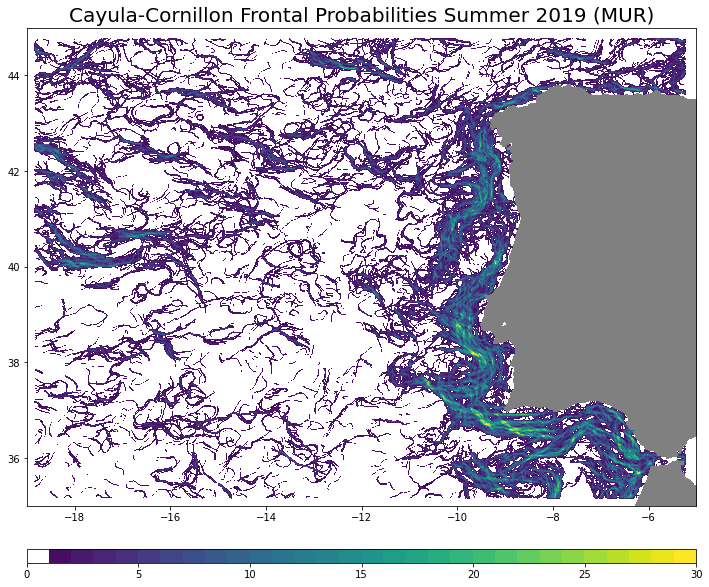

In [38]:
frente = front_visualization(specificday_mur_aug[:30], dict_df_mur_aug)

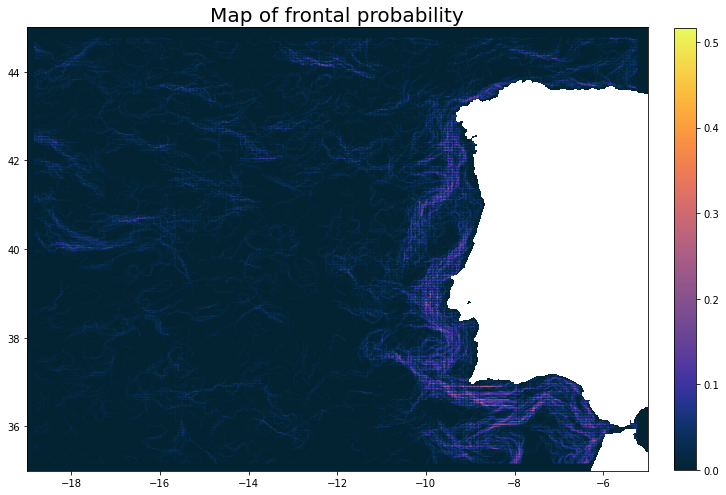

In [131]:
front_visualization(specificday_mur_aug, dict_df_mur_aug)

/tmp/ipykernel_58336/3316739692.py:50: RuntimeWarning: invalid value encountered in double_scalars
  popBMean = popBSum/popBCount
/tmp/ipykernel_58336/3316739692.py:164: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.


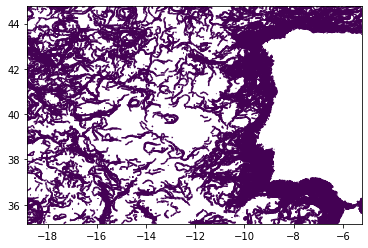

In [28]:
#code to save each day fronts in separated arrays in data directory stored as .pkl file
import pickle

for i in range(len(specificday_mur_july)):
    front = front_calc(dict_df_mur_july[specificday_mur_july[i]])
    x = specificday_mur_july[i][:10]
    pickle.dump(front, open('../data/front'+x+'.pkl', 'wb'))


In [31]:
def Merge(dict1, dict2):
    """
    Function to merge 2 dictionaires
    """
    
    res = {**dict1, **dict2}
    return res

In [32]:
dict_df_mur_augSet = Merge(dict_df_mur_aug, dict_df_mur_set)

In [33]:
dict_df_mur_summer = Merge(dict_df_mur_july, dict_df_mur_augSet)

In [34]:
dict_df_mur_summer

{'2019-07-01 09:00:00':           latitude  longitude                time     thetao
 0             35.0 -19.000000 2019-07-01 09:00:00  21.459015
 31            35.0 -18.990000 2019-07-01 09:00:00  21.488007
 62            35.0 -18.980000 2019-07-01 09:00:00  21.506012
 93            35.0 -18.969999 2019-07-01 09:00:00  21.509003
 124           35.0 -18.959999 2019-07-01 09:00:00  21.502991
 ...            ...        ...                 ...        ...
 43474276      45.0  -5.040000 2019-07-01 09:00:00  17.605988
 43474307      45.0  -5.030000 2019-07-01 09:00:00  17.605988
 43474338      45.0  -5.020000 2019-07-01 09:00:00  17.602997
 43474369      45.0  -5.010000 2019-07-01 09:00:00  17.596985
 43474400      45.0  -5.000000 2019-07-01 09:00:00  17.588989
 
 [1402401 rows x 4 columns],
 '2019-07-02 09:00:00':           latitude  longitude                time     thetao
 1             35.0 -19.000000 2019-07-02 09:00:00  21.085999
 32            35.0 -18.990000 2019-07-02 09:00:00  21.

In [35]:
specificday_mur_summer = np.concatenate([specificday_mur_july, specificday_mur_aug, specificday_mur_set])

In [36]:
specificday_mur_summer

array(['2019-07-01 09:00:00', '2019-07-02 09:00:00',
       '2019-07-03 09:00:00', '2019-07-04 09:00:00',
       '2019-07-05 09:00:00', '2019-07-06 09:00:00',
       '2019-07-07 09:00:00', '2019-07-08 09:00:00',
       '2019-07-09 09:00:00', '2019-07-10 09:00:00',
       '2019-07-11 09:00:00', '2019-07-12 09:00:00',
       '2019-07-13 09:00:00', '2019-07-14 09:00:00',
       '2019-07-15 09:00:00', '2019-07-16 09:00:00',
       '2019-07-17 09:00:00', '2019-07-18 09:00:00',
       '2019-07-19 09:00:00', '2019-07-20 09:00:00',
       '2019-07-21 09:00:00', '2019-07-22 09:00:00',
       '2019-07-23 09:00:00', '2019-07-24 09:00:00',
       '2019-07-25 09:00:00', '2019-07-26 09:00:00',
       '2019-07-27 09:00:00', '2019-07-28 09:00:00',
       '2019-07-29 09:00:00', '2019-07-30 09:00:00',
       '2019-07-31 09:00:00', '2019-08-01 09:00:00',
       '2019-08-02 09:00:00', '2019-08-03 09:00:00',
       '2019-08-04 09:00:00', '2019-08-05 09:00:00',
       '2019-08-06 09:00:00', '2019-08-07 09:0

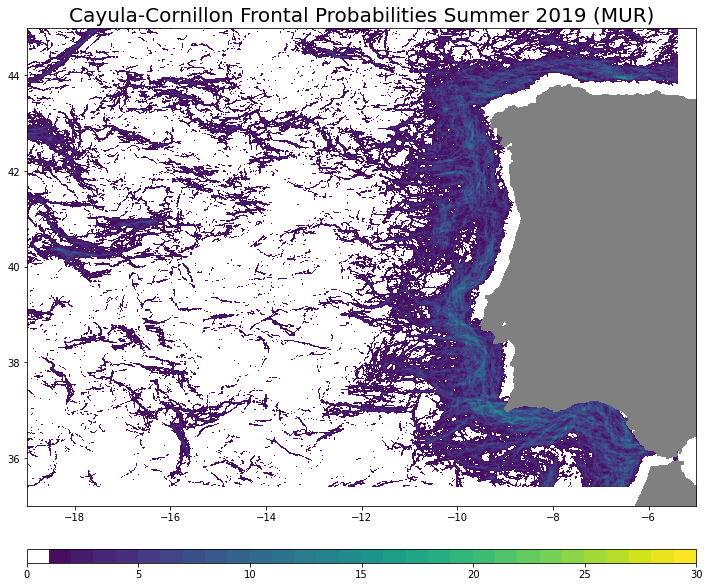

In [38]:
f = front_visualization(specificday_mur_summer, dict_df_mur_summer)

### Profiling

In [ ]:
#See how long it takes for the code to run to understand where we can make it more efficient

In [ ]:
fp_siga2 = CCA_visualization(specificday_mur_aug[:1], days_mur_aug)

/tmp/ipykernel_37677/3316739692.py:164: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
/tmp/ipykernel_37677/3316739692.py:50: RuntimeWarning: invalid value encountered in double_scalars
  popBMean = popBSum/popBCount


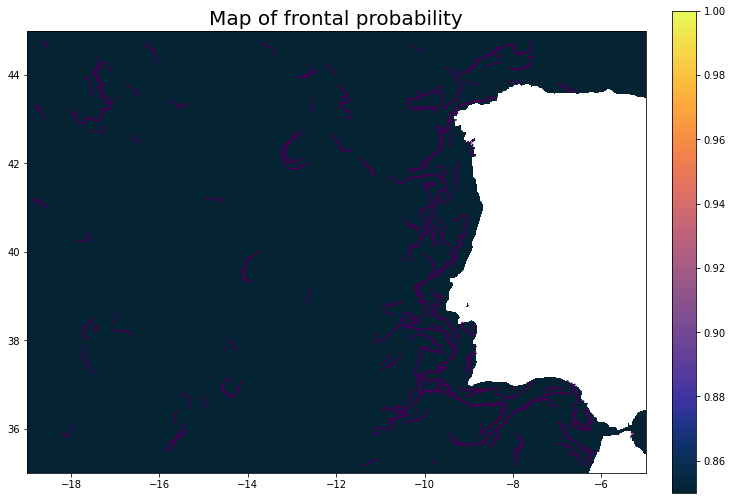

         18528775 function calls (18172051 primitive calls) in 45.503 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.006    0.006   45.503   45.503 1017502980.py:1(CCA_visualization)
        1    0.236    0.236   43.863   43.863 2581698388.py:1(CCA_SIED)
    20400    4.557    0.000   24.922    0.001 3316739692.py:1(getFrontInWindow)
     1658    0.000    0.000    0.000    0.000 3316739692.py:171(<listcomp>)
     1657    0.002    0.000    0.002    0.000 3316739692.py:179(<listcomp>)
        1    0.049    0.049   44.207   44.207 88320516.py:1(frontal_prob)
     5027    0.002    0.000    0.018    0.000 <__array_function__ internals>:2(all)
    50529    0.019    0.000    0.188    0.000 <__array_function__ internals>:2(amax)
    50522    0.019    0.000    0.217    0.000 <__array_function__ internals>:2(amin)
    47365    0.021    0.000    0.310    0.000 <__array_function__ internals>:2(any)
    47460    0.014    

    16403    0.022    0.000    0.088    0.000 histograms.py:454(_search_sorted_inclusive)
    16403    0.002    0.000    0.002    0.000 histograms.py:672(_histogram_dispatcher)
    16403    0.082    0.000    0.960    0.000 histograms.py:677(histogram)
        1    0.000    0.000    0.000    0.000 hmac.py:111(_current)
        1    0.000    0.000    0.000    0.000 hmac.py:130(hexdigest)
        4    0.000    0.000    0.000    0.000 hmac.py:94(update)
        1    0.000    0.000    0.000    0.000 hmac.py:98(copy)
      6/2    0.001    0.000    0.381    0.191 image.py:119(_draw_list_compositing_images)
       28    0.000    0.000    0.000    0.000 image.py:129(<genexpr>)
        4    0.000    0.000    0.062    0.016 image.py:165(_resample)
        1    0.000    0.000    0.000    0.000 image.py:237(__init__)
        1    0.000    0.000    0.000    0.000 image.py:276(set_alpha)
        4    0.000    0.000    0.000    0.000 image.py:294(_get_scalar_alpha)
        2    0.000    0.000    0.000

In [270]:
import cProfile

cProfile.run('CCA_visualization(specificday_mur_aug[:1], days_mur_aug)')